# 프로젝트: 가사를 이어붙이는 인공지능 

## 0. 환경 세팅

### 소요시간 확인을 위한 autotime 라이브러리 

In [1]:
# 시간 측정 
# !pip install ipython-autotime
%load_ext autotime

time: 223 µs (started: 2021-01-30 22:47:30 +09:00)


### Random seed 설정 
- 같은 결과를 유지하기 위해 설정해준다. 튜닝으로 개선할 수 도 있으나 기존 RNN을 사용한 사례에서 seed값을 일단 참고했다.

In [2]:
import os, random
import tensorflow as tf
import numpy as np 

# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 10
set_seeds(SEED)

time: 1.32 s (started: 2021-01-30 22:47:30 +09:00)


### GPU 세팅

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

time: 253 µs (started: 2021-01-30 22:47:32 +09:00)


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 137 ms (started: 2021-01-30 22:47:32 +09:00)


### 사용 라이브러리 

In [5]:
import re # 정규표현식을 활용 
import numpy as np # 변환된 문장데이터의 array로 변환 
import matplotlib.pyplot as plt # 분포의 시각화
from tensorflow.keras.preprocessing.sequence import pad_sequences # 패딩 추가
from collections import Counter # 빈도수 

from sklearn.model_selection import train_test_split # 데이터셋 분리 

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # 빨리 끝내기, 체크포인트 모델 파일 저장

time: 265 ms (started: 2021-01-30 22:47:32 +09:00)


## 1. 데이터 다운로드

### 데이터 디렉토리 만들기
* os.path.isdir(path): 주어진 경로(path)에 파일이 있으면 True, 없으면 False 반환 
* os.path.isfile(path): 주어진 경로에 파일이 있으면 True, 없으면 False 반환 

In [6]:
# import os # 위에서 이미 import 했습니다. 

project_path = os.getenv("HOME")+'/aiffel/lyricist'

if not os.path.isdir(project_path):
    os.mkdir(project_path)

else:
    print("project_path에 폴더가 이미 존재합니다.")

project_path에 폴더가 이미 존재합니다.
time: 414 µs (started: 2021-01-30 22:47:32 +09:00)


In [7]:
# 절대 경로를 줘야함. 
data_path = os.getenv("HOME")+'/aiffel/lyricist/data'
models_path = os.getenv("HOME")+'/aiffel/lyricist/models'

if not os.path.isdir(data_path):
    os.mkdir(data_path)

else:
    print("data_path에 폴더가 이미 존재합니다.")
    
if not os.path.isdir(models_path):
    os.mkdir(models_path)    

else:
    print("models_path에 폴더가 이미 존재합니다.")  

data_path에 폴더가 이미 존재합니다.
models_path에 폴더가 이미 존재합니다.
time: 819 µs (started: 2021-01-30 22:47:32 +09:00)


In [8]:
# 학습된 모델의 가중치 저장용 
chkpnt_path = models_path + "/chkpnt"

if not os.path.isdir(chkpnt_path):
    os.mkdir(chkpnt_path)    
else:
    print("chkpnt_path에 폴더가 이미 존재합니다.")  

chkpnt_path에 폴더가 이미 존재합니다.
time: 497 µs (started: 2021-01-30 22:47:32 +09:00)


### 데이터 다운로드 
* wget 라이브러리(패키지)를 설치해서 인터넷상의 다운로드 링크를 활용해서 파일을 다운로드 받을 수 있습니다.

In [9]:
!pip install wget

time: 930 ms (started: 2021-01-30 22:47:32 +09:00)


In [10]:
import wget

url = 'https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip'
zip_lyrics_path = data_path + '/song_lyrics.zip'

if not os.path.isfile(zip_lyrics_path):
    wget.download(url, out = zip_lyrics_path)

else:
    print("song_lyrics.zip가 이미 존재합니다.")

song_lyrics.zip가 이미 존재합니다.
time: 1.42 ms (started: 2021-01-30 22:47:33 +09:00)


In [11]:
!pwd #현재 위치 확인 

/home/aiffel-dj19/aiffel/lyricist
time: 115 ms (started: 2021-01-30 22:47:33 +09:00)


In [12]:
# !unzip ./data/song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics # !를 붙이면 터미널 명령으로 압축파일 해제 

time: 722 µs (started: 2021-01-30 22:47:33 +09:00)


In [13]:
# lyrics 폴더에 unzip 완료후 경로 저장
lyrics_path = os.getenv("HOME")+'/aiffel/lyricist/data/lyrics'

time: 325 µs (started: 2021-01-30 22:47:33 +09:00)


## 2. 데이터 읽어오기 
* 다운로드한 데이터를 glob 라이브러리를 활용해서 읽어옵니다. 변수명을 raw_corpus(정제되지 않은 말뭉치)로 두고, 정제하기전 초기 데이터를 불러옵니다. 

In [14]:
import glob # 파일 읽기/쓰기 작업을 위한 모듈 
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Can we forget about the things I said when I was drunk...', "I didn't mean to call you that", "I can't remember what was said"]
time: 26.9 ms (started: 2021-01-30 22:47:33 +09:00)


## 3. 데이터 정제
### 정규표현식을 활용한 필터링
* 위에서 raw_corpus를 앞부분만 봤을때, 공백인 문장이 마지막에 보입니다. 공백이 있는 문장(sentence)는 제외합니다.
* First Citizen:, All: 처럼 말하는 사람인 화자가 :를 기준으로 나타나있습니다. 따라서 화자 부분도 제외합니다.

In [15]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Can we forget about the things I said when I was drunk...
I didn't mean to call you that
I can't remember what was said
Or what you threw at me Please tell me
Please tell me why
My car is in the front yard
And I am sleeping with my cloths on
I came in throught the window... Last night
And your... Gone
Gone It's no suprise to me I am my own worst enemy
time: 827 µs (started: 2021-01-30 22:47:33 +09:00)


### Corpus 정제하는 함수: preprocess_sentence()

* 영어는 주로 공백이 토큰화에서 토큰을 쪼개는 delimeter(구분자)입니다. 
* 특수문자, 공백, 그리고 영어가 아닌 문자는 모두 공백으로 치환합니다. 
* 문장의 시작/끝 토큰 추가을 추가해줍니다. 

In [16]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 문장 앞뒤로 <start>와 <end> 토큰을 추가한다.
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample sentence . <end>
time: 812 µs (started: 2021-01-30 22:47:33 +09:00)


### Raw Corpus to Corpus 
* Corpus(말뭉치)를 의미합니다. 데이터셋의 정제되지 않은 문장들을 Corpus로 만들어 줍니다. 
* raw_corpus에서 한문장씩 읽으며 비어있는 문장이 된 문장이 있는지 확인 후에 preprocess_sentence함수로 특수문자 제거, 시작/끝 토큰 추가를 수행합니다. 

In [17]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> can we forget about the things i said when i was drunk . . . <end>',
 '<start> i didn t mean to call you that <end>',
 '<start> i can t remember what was said <end>',
 '<start> or what you threw at me please tell me <end>',
 '<start> please tell me why <end>',
 '<start> my car is in the front yard <end>',
 '<start> and i am sleeping with my cloths on <end>',
 '<start> i came in throught the window . . . last night <end>',
 '<start> and your . . . gone <end>',
 '<start> gone it s no suprise to me i am my own worst enemy <end>']

time: 1.56 s (started: 2021-01-30 22:47:33 +09:00)


### Padding 
* padding을 하기 위해서 가장 먼저 해줘야할 점은 문장의 길이가 어떻게 분포되어있는지 확인하는 것입니다.   
    왜 일까? padding은 corpus의 각 sentence(문장) 길이를 맞춰주기 위해 진행하는 작업이기 때문입니다. 길이를 너무 큰 문장에 맞춰주면 극단적으로 100이 최대길이라고 하면 문장길이가 1밖에 안되는 데이터는 99가 0으로 채워지기 떄문입니다. 그래서 주로 90% 분포에 위치하는 문장의 길이를 기준으로 padding해줍니다. 

#### 문장 분포 확인 
표준편차가 20이고, 문장길이의 평균이 51이면서 최대값은 1478이다. 굉장히 문장길이가 편중되어 분포되어있음을 알 수 있다. 

In [18]:
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in corpus]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  51.26072979078117
문장길이 최대 :  1478
문장길이 표준편차 :  20.555449915415117
time: 20 ms (started: 2021-01-30 22:47:35 +09:00)


리뷰의 최대 길이 : 1478
리뷰의 평균 길이 : 51.26072979078117


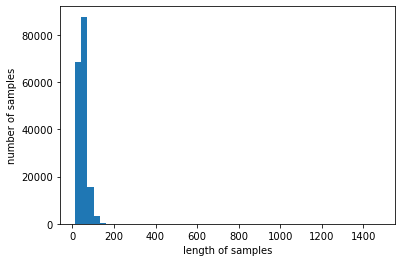

time: 696 ms (started: 2021-01-30 22:47:35 +09:00)


In [19]:
print('리뷰의 최대 길이 :', np.max(num_tokens))
print('리뷰의 평균 길이 :', np.mean(num_tokens))
plt.hist([len(s) for s in corpus], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에 히스토그램으로는 문장길이 분포를 살펴보기 어렵습니다. 히스토그램상에서 문장길이가 200이상인 경우가 대부분에 해당하는 것을 확인할 수 있기 떄문에 문장길이가 200이상인 문장에 대해서만 다시 한번 살펴봅니다.

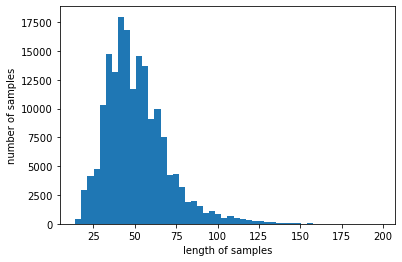

time: 668 ms (started: 2021-01-30 22:47:36 +09:00)


In [20]:
plt.hist([len(s)  for s in corpus if len(s)<200], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

반대로 문장길이가 200이상이고 최대길이에 해당하기까지의 문장 분포는 어떻게 될지 살펴봅시다. y축의 샘플의 개수를 확인해보면 앞선 히스토그램에서 17500에 비해, 25정도로 개수의 편차가 매우 큰 것을 알 수 있습니다. 

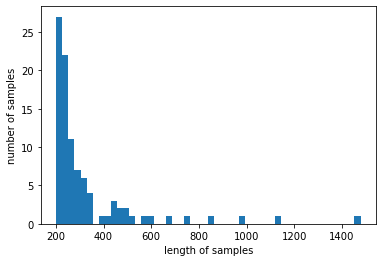

time: 158 ms (started: 2021-01-30 22:47:36 +09:00)


In [21]:
plt.hist([len(s)  for s in corpus if len(s)>200], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### Corpus 문장 길이 분포
* Corpus를 어떤 기준으로 padding해줄지에 대해서는 평균, 최대, 표준편차를 고려해줍니다.
* 왜? 평균 + 2*표준편차일까, 평균 + 표준편차는?정규분포의 지수적인 꼬리 부분에 해당하는 부분을 확인해보면 평균 + 표준편차는 약68%, 평균 + 2*표준편차는 약 95%입니다. 이러한 점을 통해 덜 극단적인 패딩의 최대 문장 길이를 선정할 수 있습니다.
* 출처: https://ko.wikipedia.org/wiki/68-95-99.7_%EA%B7%9C%EC%B9%99
~max_tokens = 15 # 문제에서는 15로 주어졌는데 왜일까? 확인해보면 매우.. 낮은데..!?~

In [22]:
max_tokens = np.mean(num_tokens) + np.std(num_tokens)

max_len = int(max_tokens)
print('pad_sequences maxlen: {}개'.format(max_len))
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen: 71개
전체 문장의 0.8815128393333674%가 maxlen 설정값 이내에 포함됩니다. 
time: 2.34 ms (started: 2021-01-30 22:47:36 +09:00)


--- 

> 잠깐만요~~~~~~ 우리가 목표하고 있는 결과물은 작사가입니다. 일반적으로 패딩의 길이를 정해줄 때, 위와 같은 방법으로 히스토그램을 살펴본 후 가장 일반적인 길이를 선정해줍니다. 그래서 되도록 길이를 20 정도로 일반적인 노랫말들이 문장길이가 20정도 된다고 생각하고 max_len을 30으로 지정해주겠습니다. start와 end를 생각하면 글자 수는 10개 정도가 빠지는 거니까요  

In [23]:
max_len = 30 

time: 276 µs (started: 2021-01-30 22:47:36 +09:00)


### 토큰화와 벡터화 ( + 패딩)
* keras를 활용해 데이터를 토큰화하고 단어 사전을 만들어 줍니다. 이 과정에서 데이터를 숫자로 인코딩해줍니다. 
* 여기서 index_word가 바로 단어 사전입니다. 말뭉치 -> 토큰화 -> 정수인코딩 -> 패딩의 과정을 거쳐 만들어집니다. 

#### 토크나이저의 단어사전 크기 설정: Counter
빈도수를 기준으로 자주 언급된 단어를 중심으로 데이터셋을 추릴 예정이다. 주로 자연어 처리에서 1번 언급된 문장은 제거해줍니다. 2번도 적은거 같아서 저는 여기서 3회 이상 언급된 문장만 살렸습니다. 

In [24]:
corpus[:10]

['<start> can we forget about the things i said when i was drunk . . . <end>',
 '<start> i didn t mean to call you that <end>',
 '<start> i can t remember what was said <end>',
 '<start> or what you threw at me please tell me <end>',
 '<start> please tell me why <end>',
 '<start> my car is in the front yard <end>',
 '<start> and i am sleeping with my cloths on <end>',
 '<start> i came in throught the window . . . last night <end>',
 '<start> and your . . . gone <end>',
 '<start> gone it s no suprise to me i am my own worst enemy <end>']

time: 1.64 ms (started: 2021-01-30 22:47:36 +09:00)


In [25]:
# Counter 사용 예시 
print(Counter(['hey jude', 'dont be afraid', 'hey jude', 'chorus', 'jyp', 'jyp']).most_common(3)) # 빈도수가 3이상인 글자만? (X), 빈도수 상위 3위까지 딕셔너리로 출력한다.

[('hey jude', 2), ('jyp', 2), ('dont be afraid', 1)]
time: 741 µs (started: 2021-01-30 22:47:36 +09:00)


In [26]:
counter = Counter(corpus)
counter_for_vocabsize = counter.most_common() # counter는 key인 글자와 value인 빈도수(등장횟수)로 이뤄져있다. 

counter_for_vocabsize[:10] # 앞에 10개만 

[('<start> chorus <end>', 204),
 ('<start> yeah <end>', 120),
 ('<start> come <end>', 85),
 ('<start> you nasty boy you nasty <end>', 84),
 ('<start> go , get ur freak on <end>', 60),
 ('<start>  <end>', 53),
 ('<start> come on motherfuckers come on <end>', 48),
 ('<start> oh <end>', 46),
 ('<start> its bone and biggie biggie <end>', 46),
 ('<start> just bone and biggie biggie <end>', 44)]

time: 42 ms (started: 2021-01-30 22:47:36 +09:00)


In [27]:
rare_cnt = 0

# # 빈도수를 2회 이상을 기준으로 잡아준다. 
for index in range(len(counter_for_vocabsize)):
    if counter_for_vocabsize[index][1] < 3: # 3회 이상인 대상은 많기 때문에 1회인 대상을 센다.
        rare_cnt = rare_cnt + 1

print("{}개의 2회 미만에 해당하는 단어가 있습니다.".format(rare_cnt))

vocab_size_ = len(corpus) - rare_cnt
print("vocab size는 {}개 입니다.".format(vocab_size_))

107579개의 2회 미만에 해당하는 단어가 있습니다.
vocab size는 68170개 입니다.
time: 17.4 ms (started: 2021-01-30 22:47:36 +09:00)


In [28]:
print("{}개의 글자 묶음에서 빈도수 상위 {}위에 속하는 단어만으로 단어사전을 만들었습니다".format(len(corpus), vocab_size_))

175749개의 글자 묶음에서 빈도수 상위 68170위에 속하는 단어만으로 단어사전을 만들었습니다
time: 489 µs (started: 2021-01-30 22:47:36 +09:00)


In [29]:
vocab = [key for key, _ in counter_for_vocabsize[:vocab_size_]]
corpus = vocab # 개수를 줄인 corpus
vocab[:10]

['<start> chorus <end>',
 '<start> yeah <end>',
 '<start> come <end>',
 '<start> you nasty boy you nasty <end>',
 '<start> go , get ur freak on <end>',
 '<start>  <end>',
 '<start> come on motherfuckers come on <end>',
 '<start> oh <end>',
 '<start> its bone and biggie biggie <end>',
 '<start> just bone and biggie biggie <end>']

time: 7.99 ms (started: 2021-01-30 22:47:36 +09:00)


### Tokenizer 
* tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
```
ResourceExhaustedError: OOM when allocating tensor with shape[17920,10001] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MatMul]
```
단어 사전 크기에 해당하는 num_words에는 6만개로 한다면 현재 RTX 2070 GPU는 out of memory가 될 확률이 높습니다. 그래서 임의로 좀더 줄여주는 것이 좋습니다.    
그럼 위의 과정은 쓸모가 없어질까요? 그건 아니라고 생각됩니다. 빈도수가 많은 문장을 기준으로 살려뒀기 때문에 좀 더 일반적인 데이터셋이 됬다고 볼 수 있기 때문입니다.     

In [30]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words= 15000,  # 임의의 단어사전의 크기  
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 <unk> 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           maxlen = max_len + 1, 
                                                           padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  308    3 ...    0    0    0]
 [   2   51    3 ...    0    0    0]
 [   2   75    3 ...    0    0    0]
 ...
 [   2   21  598 ...    0    0    0]
 [   2 1460  159 ...    0    0    0]
 [   2   21  342 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f887ea29e10>
time: 1.2 s (started: 2021-01-30 22:47:36 +09:00)


#### 패딩 확인
확인 결과 토큰나이저에서 정수인코딩이 <start>는 2로, <end> 토큰은 3으로 인코딩했음을 알 수 있습니다. 
0은 패딩이고 아마 1은 unk 토큰일듯합니다. 

In [31]:
print(len(tensor))
print(tensor[:10, :10])

68170
[[   2  308    3    0    0    0    0    0    0    0]
 [   2   51    3    0    0    0    0    0    0    0]
 [   2   75    3    0    0    0    0    0    0    0]
 [   2    7  758  167    7  758    3    0    0    0]
 [   2   54    5   40 1203  965   18    3    0    0]
 [   2    3    0    0    0    0    0    0    0    0]
 [   2   75   18  656   75   18    3    0    0    0]
 [   2   46    3    0    0    0    0    0    0    0]
 [   2  146 1028    8  522  522    3    0    0    0]
 [   2   32 1028    8  522  522    3    0    0    0]]
time: 590 µs (started: 2021-01-30 22:47:38 +09:00)


## 4. 데이터셋 분리 

In [32]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[  2 308   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
[308   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]
time: 10.5 ms (started: 2021-01-30 22:47:38 +09:00)


### 데이터셋 분리 

In [33]:
X_train, X_val, y_train, y_val = train_test_split(src_input,
                                                  tgt_input,
                                                  test_size = 0.2,
                                                  shuffle = True
                                                 )

print("Source Train: ", X_train.shape)
print("Target Train: ", y_train.shape)
print("Source Test: ", X_val.shape)
print("Target Test: ", y_val.shape)

Source Train:  (54536, 30)
Target Train:  (54536, 30)
Source Test:  (13634, 30)
Target Test:  (13634, 30)
time: 15.1 ms (started: 2021-01-30 22:47:38 +09:00)


### Hyper-parameter

In [34]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VALIDATION_STEPS = len(X_val) // BATCH_SIZE
# steps_per_epoch = len(src_input) // BATCH_SIZE

time: 379 µs (started: 2021-01-30 22:47:38 +09:00)


### 떼이터셋 객체로 변환
* tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

In [35]:
tokenizer.num_words

15000

time: 973 µs (started: 2021-01-30 22:47:38 +09:00)


In [36]:
VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
test_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(BUFFER_SIZE)
test_data = test_data.batch(BATCH_SIZE, drop_remainder=True)
train_data, test_data

(<BatchDataset shapes: ((256, 30), (256, 30)), types: (tf.int32, tf.int32)>,
 <BatchDataset shapes: ((256, 30), (256, 30)), types: (tf.int32, tf.int32)>)

time: 306 ms (started: 2021-01-30 22:47:38 +09:00)


## 5. 모델 설계 및 학습
Subclassing 방식으로 설계한 모델을 만들어봅니다. 

In [37]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        # 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔줍니다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

vocab_size = VOCAB_SIZE
embedding_size = 256 # 단어가 추상적으로 표현되는 크기로서 CNN으로 생각하면 몇개의 특징을 추출할지 결정하는 인자입니다. 
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # 단어 사전의 크기 tokenizer.num_words + 1

time: 12.8 ms (started: 2021-01-30 22:47:38 +09:00)


In [38]:
for src_sample, tgt_sample in train_data.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 30, 15001), dtype=float32, numpy=
array([[[ 1.7854638e-04, -8.5614367e-05, -3.4758454e-05, ...,
          7.6550114e-06, -1.6756621e-06, -2.3023027e-05],
        [ 2.4356316e-04, -1.6279450e-04, -7.7648001e-05, ...,
          1.5617604e-04,  2.2965934e-04,  1.0720167e-04],
        [ 2.5693839e-04, -2.3204906e-04, -1.0803305e-04, ...,
          2.1518796e-04,  6.1905116e-04,  8.0284597e-05],
        ...,
        [ 1.0932746e-03,  1.6300996e-03, -1.8128823e-03, ...,
         -1.9426933e-03, -2.3727834e-03, -9.9345503e-05],
        [ 1.1037459e-03,  1.6505937e-03, -1.7912129e-03, ...,
         -1.9707214e-03, -2.4445818e-03, -7.6092780e-05],
        [ 1.1084013e-03,  1.6647433e-03, -1.7720705e-03, ...,
         -1.9904191e-03, -2.5071299e-03, -5.4221338e-05]],

       [[ 1.7854638e-04, -8.5614367e-05, -3.4758454e-05, ...,
          7.6550114e-06, -1.6756621e-06, -2.3023027e-05],
        [ 1.8485765e-04, -2.0664210e-04, -2.6732701e-05, ...,
          1.6446655e-05, 

time: 3.94 s (started: 2021-01-30 22:47:38 +09:00)


In [39]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3840256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  15376025  
Total params: 32,855,961
Trainable params: 32,855,961
Non-trainable params: 0
_________________________________________________________________
time: 1.47 ms (started: 2021-01-30 22:47:42 +09:00)


### Hyper-parameter 
목표하는 val_loss는 2.2% 수준으로 낮춰야한다. 

In [40]:
# BUFFER_SIZE = len(src_input)
# BATCH_SIZE = 256
# steps_per_epoch = len(src_input) // BATCH_SIZE
# 위에서 데이터셋 텐서로 바꿔줄 때 이미 정의한 파라미터들 

MAX_EPOCHS = 10  
LEARNING_RATE = 1e-4

time: 295 µs (started: 2021-01-30 22:47:42 +09:00)


### 모델 학습 

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
cp_callback = tf.keras.callbacks.ModelCheckpoint(chkpnt_path + '/lyrics',
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

time: 616 µs (started: 2021-01-30 22:47:42 +09:00)


In [42]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

time: 430 µs (started: 2021-01-30 22:47:42 +09:00)


In [43]:
model.compile(loss=loss, optimizer=optimizer,
             metrics=['accuracy'])
hist_model = model.fit(train_data, 
                       steps_per_epoch = STEPS_PER_EPOCH,
                       validation_data = test_data, 
                       validation_steps = VALIDATION_STEPS,
                       epochs= MAX_EPOCHS,
                      callbacks = [es, cp_callback])

Epoch 1/10
213/213 [==============================] - ETA: 0s - loss: 3.3234 - accuracy: 0.6651
Epoch 00001: val_loss improved from inf to 2.48548, saving model to /home/aiffel-dj19/aiffel/lyricist/models/chkpnt/lyrics
213/213 [==============================] - 69s 323ms/step - loss: 3.3234 - accuracy: 0.6651 - val_loss: 2.4855 - val_accuracy: 0.6680
Epoch 2/10
213/213 [==============================] - ETA: 0s - loss: 2.2981 - accuracy: 0.6719
Epoch 00002: val_loss improved from 2.48548 to 2.15491, saving model to /home/aiffel-dj19/aiffel/lyricist/models/chkpnt/lyrics
213/213 [==============================] - 70s 328ms/step - loss: 2.2981 - accuracy: 0.6719 - val_loss: 2.1549 - val_accuracy: 0.6796
Epoch 3/10
213/213 [==============================] - ETA: 0s - loss: 2.0711 - accuracy: 0.6976
Epoch 00003: val_loss improved from 2.15491 to 2.02601, saving model to /home/aiffel-dj19/aiffel/lyricist/models/chkpnt/lyrics
213/213 [==============================] - 69s 323ms/step - loss: 2

### 학습 결과 시각화 

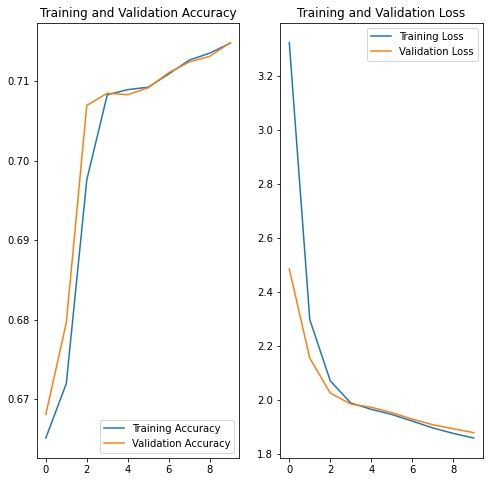

time: 204 ms (started: 2021-01-30 23:00:18 +09:00)


In [45]:
acc = hist_model.history['accuracy']
val_acc = hist_model.history['val_accuracy']

loss=hist_model.history['loss']
val_loss=hist_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. 모델 Test

In [47]:
model.load_weights(chkpnt_path + '/lyrics')
results = model.evaluate(test_data)

53/53 [==============================] - 6s 113ms/step - loss: 1.8795 - accuracy: 0.7148
time: 6.42 s (started: 2021-01-30 23:00:53 +09:00)


In [48]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
																 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

time: 851 µs (started: 2021-01-30 23:01:03 +09:00)


In [49]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love you the t the be <end> '

time: 50 ms (started: 2021-01-30 23:01:05 +09:00)
